# Predict Financial News Sentiment

### Environment
Ubuntu 22.04 LTS which includes **Python 3.9.12** and utilities *curl*, *git*, *vim*, *unzip*, *wget*, and *zip*. There is no *GPU* support.

The IPython Kernel allows you to execute Python code in the Notebook cell and Python console.

### Installing packages
- Run `!mamba list "package_name"` command to check the package installation status. For example,

```python
!mamba list numpy
"""
# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
numpy                     1.21.6           py39h18676bf_0    conda-forge
"""
```

    You can also try importing the package.

- Run the `!mamba install "package_name"` to install a package

### Excluding large files
HackerRank rejects any submission larger than **20MB**. Therefore, you must exclude any large files by adding these to the *.gitignore* file.
You can **Submit** code to validate the status of your submission.

In [7]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

pd.set_option("display.max_columns", 101)
pd.set_option("display.max_colwidth", None)

## Data Description

| Column    | Description                                         |
|:----------|:----------------------------------------------------|
| `news`  | news headline                                |
| `label`   | news sentiment - negative (`0`), neutral (`1`), positive (`2`) |

In [8]:
# The training dataset is already loaded below.
data = pd.read_csv("train.csv")
data.head()

,news,label
0,Residents access to the block is planned to be from Aleksandri Street .,1
1,"The company operates its business through two reportable segments , including Banking and Investment Services , and Non-Life Insurance .",1
2,"However , this increases signaling traffic which wastes network resources and allows fewer smartphones to connect .",0
3,"Ahlstrom Corporation STOCK EXCHANGE RELEASE 13.02.2008 Ahlstrom , a global leader in high performance fiber-based materials , today announced the completion of the acquisition of Friend Group Inc. , which consists of West Carrollton Parchment Company and West Carrollton Converting Company .",1
4,The winners included the Honda Odyssey for minivan and the Nissan Armada for large SUV .,1


In [2]:
# Cell 1: imports & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

train_path = "train.csv"
test_path  = "test.csv"

tr = pd.read_csv(train_path)
te = pd.read_csv(test_path)

# basic hygiene
for df in (tr, te):
    df["news"] = df["news"].fillna("").astype(str)
tr.head()


,news,label
0,Residents access to the block is planned to be...,1
1,The company operates its business through two ...,1
2,"However , this increases signaling traffic whi...",0
3,Ahlstrom Corporation STOCK EXCHANGE RELEASE 13...,1
4,The winners included the Honda Odyssey for min...,1


In [3]:
# Cell 2: char & word lengths
def add_basic_lengths(df):
    s = df["news"]
    df["len_char"] = s.str.len()
    df["len_word"] = s.str.split().apply(len)
    return df

tr = add_basic_lengths(tr)
te = add_basic_lengths(te)

tr[["len_char","len_word"]].describe(percentiles=[.5,.9,.95,.99]).round(1)


,len_char,len_word
count,3634.0,3634.0
mean,128.6,23.1
std,56.6,9.9
min,11.0,3.0
50%,120.0,21.0
90%,212.0,38.0
95%,236.0,42.0
99%,274.7,50.0
max,315.0,81.0


In [4]:
# Cell 3: tokenizer-based lengths
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def bert_len(texts, tokenizer, batch_size=1024, max_length=512):
    out = np.empty(len(texts), dtype=np.int32)
    for i in range(0, len(texts), batch_size):
        enc = tokenizer(
            texts[i:i+batch_size],
            truncation=False,   # count true length
            padding=False,
            add_special_tokens=True,
            return_attention_mask=False,
            return_token_type_ids=False,
        )
        # input_ids includes [CLS]/[SEP] equivalents already
        out[i:i+batch_size] = [len(ids) for ids in enc["input_ids"]]
    return out

tr["len_tok"] = bert_len(tr["news"].tolist(), tok)
te["len_tok"] = bert_len(te["news"].tolist(), tok)

tr[["len_tok"]].describe(percentiles=[.5,.9,.95,.99]).round(1)


/opt/anaconda3/envs/pds/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/pds/lib/python3.9/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,len_tok
count,3634.0
mean,30.6
std,13.7
min,5.0
50%,28.0
90%,50.0
95%,57.0
99%,69.0
max,150.0


In [5]:
# Cell 4: coverage at common max_len choices
candidates = [96, 128, 160, 192, 256]
def coverage(df, col="len_tok"):
    n = len(df)
    rows = []
    for L in candidates:
        covered = (df[col] <= L).mean()
        rows.append({"max_len": L, "covered_%": round(100*covered, 2), "truncated_n": int((1-covered)*n)})
    return pd.DataFrame(rows)

cov_tr = coverage(tr, "len_tok")
cov_te = coverage(te, "len_tok")
print("Train coverage:")
display(cov_tr)
print("Test coverage:")
display(cov_te)


Train coverage:


,max_len,covered_%,truncated_n
0,96,99.92,3
1,128,99.97,0
2,160,100.00,0
3,192,100.00,0
4,256,100.00,0


Test coverage:


,max_len,covered_%,truncated_n
0,96,99.92,1
1,128,100.00,0
2,160,100.00,0
3,192,100.00,0
4,256,100.00,0


In [6]:
# Cell 5: percentiles overall & by label
def pct_table(df, col):
    qs = [0.5, 0.9, 0.95, 0.99]
    vals = np.percentile(df[col], [q*100 for q in qs])
    return pd.DataFrame({"percentile": ["50%","90%","95%","99%"], col: vals.astype(int)})

print("Overall (BERT tokens):")
display(pct_table(tr, "len_tok"))

if "label" in tr.columns:
    # per-label percentiles
    frames = []
    for y, g in tr.groupby("label", sort=True):
        t = pct_table(g, "len_tok")
        t.insert(0, "label", y)
        frames.append(t)
    display(pd.concat(frames, ignore_index=True))


Overall (BERT tokens):


,percentile,len_tok
0,50%,28
1,90%,50
2,95%,57
3,99%,69


,label,percentile,len_tok
0,0,50%,30
1,0,90%,54
2,0,95%,62
3,0,99%,69
4,1,50%,27
5,1,90%,48
6,1,95%,55
7,1,99%,68
8,2,50%,30
9,2,90%,51


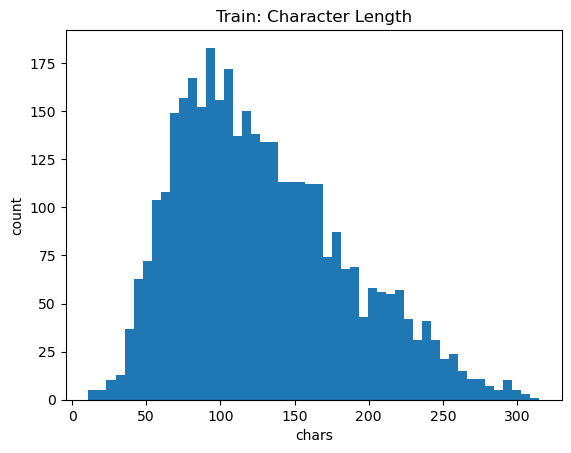

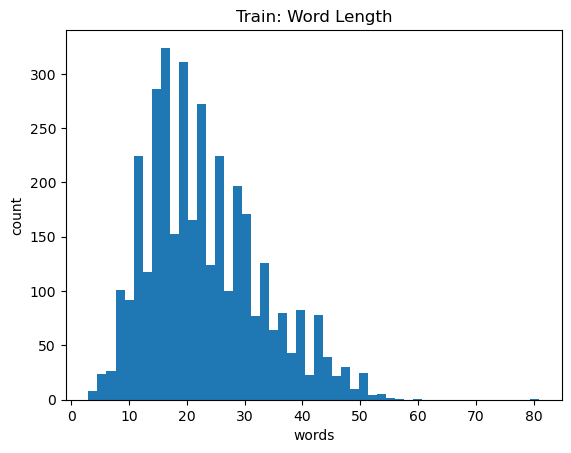

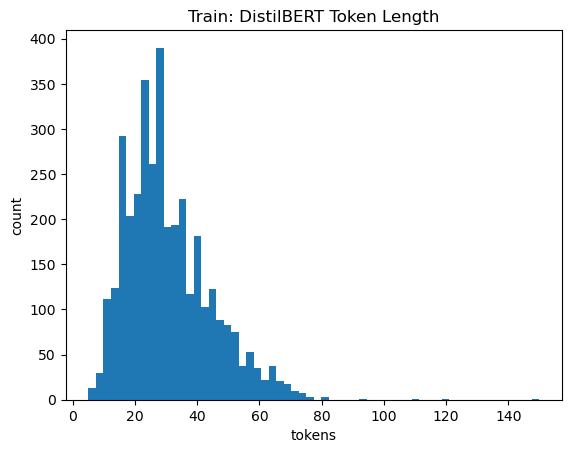

In [7]:
# Cell 6: histograms (1 plot per chart; default matplotlib styles)
fig = plt.figure()
plt.hist(tr["len_char"], bins=50)
plt.title("Train: Character Length")
plt.xlabel("chars"); plt.ylabel("count")
plt.show()

fig = plt.figure()
plt.hist(tr["len_word"], bins=50)
plt.title("Train: Word Length")
plt.xlabel("words"); plt.ylabel("count")
plt.show()

fig = plt.figure()
plt.hist(tr["len_tok"], bins=60)
plt.title("Train: DistilBERT Token Length")
plt.xlabel("tokens"); plt.ylabel("count")
plt.show()


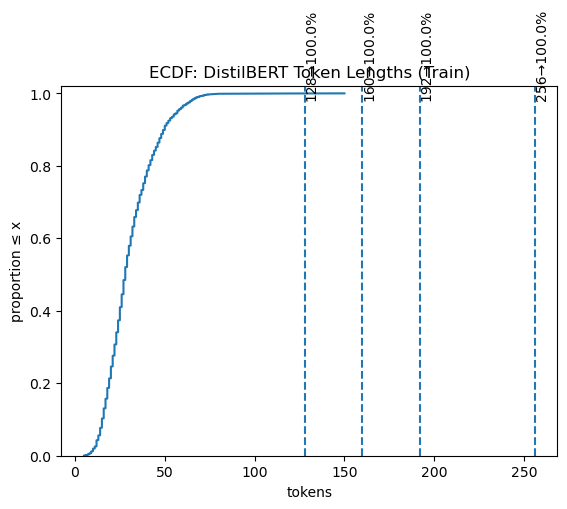

In [8]:
# Cell 7: ECDF for token lengths
x = np.sort(tr["len_tok"].values)
y = np.arange(1, len(x)+1) / len(x)

fig = plt.figure()
plt.plot(x, y)
for L in [128, 160, 192, 256]:
    # draw vertical helper
    idx = np.searchsorted(x, L, side="right")
    pct = idx / len(x)
    plt.axvline(L, linestyle="--")
    plt.text(L, min(0.98, pct+0.02), f"{L}→{pct*100:.1f}%", rotation=90, va="bottom")
plt.title("ECDF: DistilBERT Token Lengths (Train)")
plt.xlabel("tokens"); plt.ylabel("proportion ≤ x")
plt.ylim(0,1.02)
plt.show()


/var/folders/5w/ff16971n7g373q3_zm275bpr0000gn/T/ipykernel_2702/2775035474.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


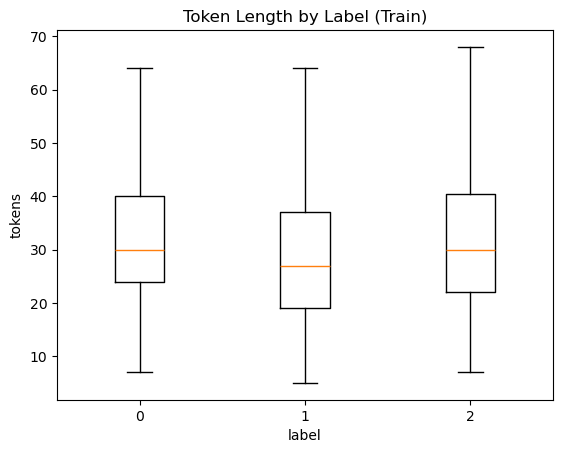

In [9]:
# Cell 8: per-class boxplots for token length (matplotlib)
if "label" in tr.columns:
    order = sorted(tr["label"].unique())
    data = [tr.loc[tr["label"]==y, "len_tok"].values for y in order]
    fig = plt.figure()
    plt.boxplot(data, labels=order, showfliers=False)
    plt.title("Token Length by Label (Train)")
    plt.xlabel("label"); plt.ylabel("tokens")
    plt.show()


In [10]:
# Cell 9: look at longest texts
k = 5
long_idx = tr["len_tok"].nlargest(k).index
tr.loc[long_idx, ["label","len_tok","len_word","len_char","news"]]


,label,len_tok,len_word,len_char,news
2824,1,150,81,315,"Supported Nokia phones include : N96 , N95-8GB..."
3205,1,120,29,255,----------------------------------------------...
1703,1,109,52,262,"H1 '08 H1 '07 Q2 '08 Q2 '07 in mln euro , unle..."
2711,1,93,57,273,3 January 2011 - Scandinavian lenders Sampo Ba...
586,2,80,55,258,narrows to EUR2 .8 m 9-mo '09 29 October 2009 ...


In [11]:
# Cell 10: print a simple recommendation based on 95th percentile
p95 = int(np.percentile(tr["len_tok"], 95))
choice = min([L for L in [128,160,192,256] if L >= p95] or [256])
print(f"95th percentile of token length = {p95}.")
print(f"Suggested max_len: {choice} (covers ≥95% with minimal truncation).")


95th percentile of token length = 57.
Suggested max_len: 128 (covers ≥95% with minimal truncation).


Thus, we can reduce max_len to 128 and increase batch size. This helps to increase the training efficiency, allowing more fine-tuning.

## Deep Learning

Build a neural network that can predict the news sentiment.
- **The model's performance will be evaluated on the basis of weighted F1 score.**

During the EDA process, I found that the labels are skewed (≈12% label 0, ≈60% label 1, ≈28% label 2). I therefore used oversampling to increase the number of label 0 and label 2 training samples. Because the training dataset is relatively small, I chose transfer learning over training a model from scratch.

I started with DistilBERT. Oversampling improved results compared to no oversampling. Also, it avoids the problem of overfitting due to skewed dataset. After trying several oversampling factors, 1.3 worked best. Exploring learning rate, max sequence length, and batch size, two settings gave solid results:

DistilBERT (baseline)
model=distilbert-base-uncased, max_len=160, epochs=3, train_bs=16, eval_bs=32, lr=4e-5
Result: Accuracy 0.831, F1-weighted 0.832, F1-macro 0.809.

DistilBERT (label smoothing + step eval + oversampling)
model=distilbert-base-uncased, max_len=128, epochs=4, train_bs=32, eval_bs=64, lr=4e-5, ls=0.05, eval_steps=80, oversample=1.3
Result: Accuracy 0.838, F1-weighted 0.838, F1-macro 0.826.

Then I tried RoBERTa-base. It consistently outperformed DistilBERT. The best result came from:

RoBERTa-base (final choice)
model=roberta-base, max_len=160, epochs=3, train_bs=16, eval_bs=32, lr=4e-5, ls=0.02, eval_steps=80, oversample=1.3 Result: Acc 0.865, F1-weighted 0.865, F1-macro 0.851.
Artifact: artifacts_nn/roberta-base_lr4e-05_len160_bs16_e3_ls0.02_os1.3_20251005-182129/
(contains metrics.json, classification_report.txt, and submission_*.csv).

Unfortunately, RoBERTa-base training for the model =roberta-base, max_len=128, epochs=4, train_bs=32, eval_bs=64, lr=4e-5, ls=0.05, eval_steps=80, oversample=1.3 was too time-consuming on my hardware for this project’s timeline, so I did not pursue it further.

Lastly I tried with Deberta-v3. Unfortunately, it's still too time cosuming on my hardware for this project’s timeline, so I did not pursue it further.

Thus, I will submit the RoBERTa-base model with the configuration above. A manual review of the prediction file looked sensible: most label 0 predictions read as clearly negative, most label 2 predictions as clearly positive, and most label 1 predictions as neutral.

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (test.csv), predict the value of the `label` variable.  You should submit a CSV file with a header row and one row per test entry.

The file (`submissions.csv`) should have exactly 2 columns:

| Column    | Description                                         |
|:----------|:----------------------------------------------------|
| `news`  | news headline                                |
| `label`   | news sentiment - negative (`0`), neutral (`1`), positive (`2`) |

In [9]:
# The testing dataset is already loaded below.
test = pd.read_csv("test.csv")
test.head()

,news
0,"The company was supposed to deliver machinery to a veneer mill in the Tomsk region , in Russia ."
1,UNC Charlotte would also deploy SSH Tectia Connector to enable secure application connectivity .
2,"In 2009 , Lee & Man had a combined annual production capacity of close to 4.5 million tonnes of paper and 300,000 tonnes of pulp ."
3,"`` That 's a very high figure on the European scale , '' Noop said , recalling however that this also includes beer bought by Finnish tourists ."
4,"In Finland , the corresponding service is Alma Media 's Etuovi.com , Finland 's most popular and best known nationwide online service for home and property sales ."


In [ ]:
# Submission
submission_df.to_csv("submissions.csv", index=False)